In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import *
from clvlib.numpy import lyap_analysis, compute_ICLE

ModuleNotFoundError: No module named 'clvlib'

In [ ]:
np.seterr(divide="ignore", over="ignore", invalid="ignore")
data = np.load("benchmarks/lorenz96_solution.npz", allow_pickle=True)
t_loaded = data["t"]
x_loaded = data["x"]
x_loaded = x_loaded.T  # Transpose to shape (N, len(t))
F = 8

In [21]:
def lorenz96(t, X, F=10):
        Xdot = np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) - X + F
        return Xdot

def lorenz96_jacobian(t, X, F=10):
    K = len(X)
    # Initialize the Jacobian matrix
    J_xx = np.zeros((K, K))
    idx = np.arange(K)
    idx_im1 = (idx - 1) % K  # X[i-1]
    idx_ip1 = (idx + 1) % K  # X[i+1]
    idx_im2 = (idx - 2) % K  # X[i-2]
    J_xx[idx, idx_im1] = X[idx_ip1] - X[idx_im2]
    J_xx[idx, idx_ip1] = X[idx_im1]
    J_xx[idx, idx_im2] = -X[idx_im1]
    J_xx[idx, idx] = -1

    return J_xx

In [22]:
def lorenz63(t: float, x: np.ndarray, sigma: float = 10.0, beta: float = 8.0 / 3, rho: float = 28.0) -> np.ndarray:
    """
    Computes the time derivatives of the Lorenz '63 system, a classic chaotic system.

    The Lorenz system is defined by the following equations:
        dx/dt = sigma * (y - x)
        dy/dt = x * (rho - z) - y
        dz/dt = x * y - beta * z

    Parameters:
        t (float): Time variable (not used directly in the Lorenz system, but kept for compatibility with solvers).
        x (np.ndarray): State vector of the system [x, y, z].
        sigma (float): Prandtl number, controlling the rate of convection (default: 10.0).
        beta (float): Geometric factor, related to the physical properties of the system (default: 8/3).
        rho (float): Rayleigh number, related to the temperature difference driving the system (default: 28.0).

    Returns:
        np.ndarray: Time derivatives [dx/dt, dy/dt, dz/dt] as a 1D NumPy array.
    """
    # Unpack state variables for clarity
    x1, x2, x3 = x  # x1 -> x, x2 -> y, x3 -> z

    # Lorenz '63 system equations
    dx1_dt = sigma * (x2 - x1)          # dx/dt
    dx2_dt = x1 * (rho - x3) - x2       # dy/dt
    dx3_dt = x1 * x2 - beta * x3        # dz/dt

    # Return the time derivatives as a NumPy array
    return np.array([dx1_dt, dx2_dt, dx3_dt])


def lorenz63_jacobian(t: float, x: np.ndarray, sigma: float = 10.0, beta: float = 8.0 / 3, rho: float = 28.0) -> np.ndarray:
    """
    Computes the Jacobian matrix of the Lorenz '63 system at a given state.

    The Jacobian represents the linearization of the Lorenz system's dynamics around a specific state (x, y, z):
        dx/dt = sigma * (y - x)
        dy/dt = x * (rho - z) - y
        dz/dt = x * y - beta * z

    Parameters:
        t (float): Time variable (not used directly, kept for compatibility with solvers).
        x (np.ndarray): State vector of the system [x, y, z].
        sigma (float): Prandtl number, controlling the rate of convection (default: 10.0).
        beta (float): Geometric factor, related to the system's physical properties (default: 8/3).
        rho (float): Rayleigh number, related to the temperature difference driving the system (default: 28.0).

    Returns:
        np.ndarray: Jacobian matrix (3x3) evaluated at the current state as a NumPy array.
    """
    # Unpack state variables for clarity
    x1, x2, x3 = x  # x1 -> x, x2 -> y, x3 -> z

    # Define the Jacobian matrix of the Lorenz system
    jacobian = [
        [-sigma,       sigma,    0.0],       # Partial derivatives of dx/dt
        [rho - x3,     -1.0,    -x1],        # Partial derivatives of dy/dt
        [x2,           x1,      -beta]       # Partial derivatives of dz/dt
    ]

    # Convert to a NumPy array for convenient numerical use
    return np.array(jacobian)

In [ ]:
x, Q, R, LE, LE_history, CLVs = lyap_analysis(lorenz96, lorenz96_jacobian, x0, t, F, k_step=1)

Using standard Lyapunov integration (k_step = 1)


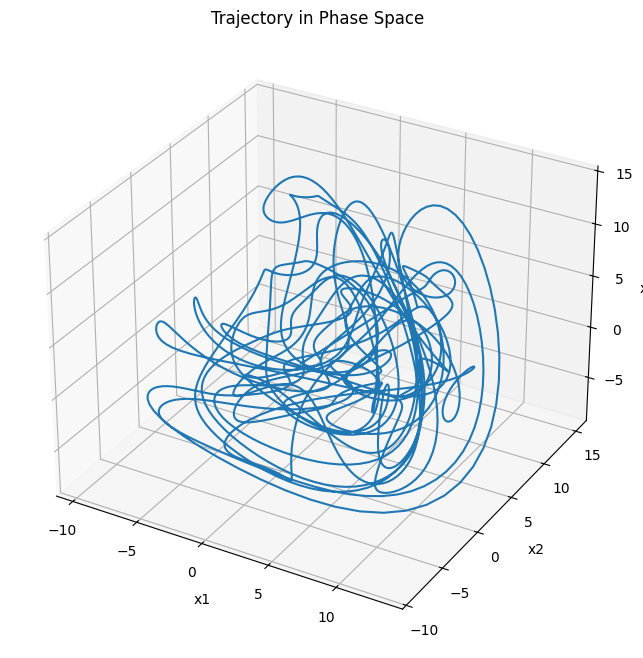

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.plot(x[0, :], x[1, :], x[2, :])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_title("Trajectory in Phase Space")
plt.show()


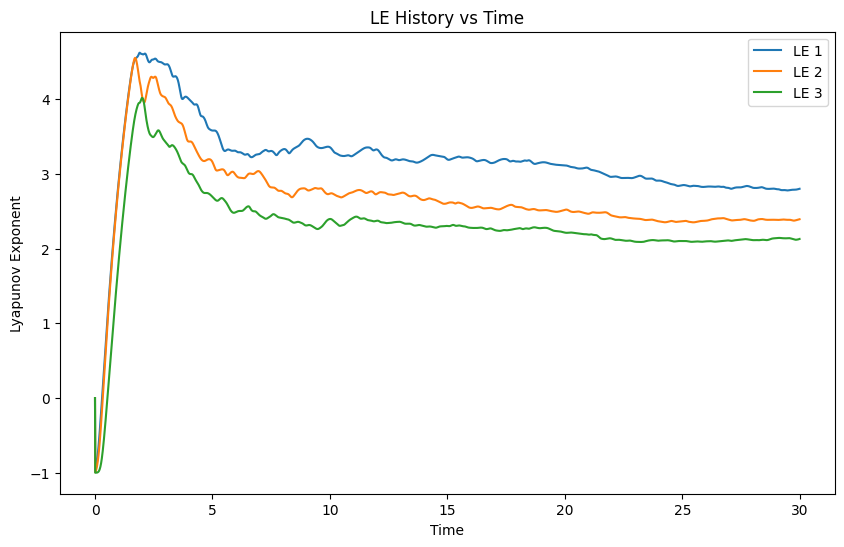

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, LE_history[0, :], label='LE 1')
plt.plot(t, LE_history[1, :], label='LE 2')
plt.plot(t, LE_history[2, :], label='LE 3')
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.title('LE History vs Time')
plt.legend()
plt.show()

In [ ]:
print("Final Lyapunov Exponents:", LE)

Final Lyapunov Exponents: [ 2.8026124   2.39477028  2.13076136  2.0057079   1.80570489  1.49421835
  1.43450356  1.23640415  1.26039574  1.12992131  0.8689069   0.73852876
  0.73906899  0.58384461  0.35082205  0.29220605  0.19833883 -0.06770735
  0.017726   -0.0570844  -0.15618008 -0.35980433 -0.40374522 -0.57013553
 -0.69985856 -0.72754635 -0.84778203 -1.04755749 -1.09285425 -1.19875361
 -1.33492487 -1.48099918 -1.55366889 -1.73814377 -1.78697366 -2.08850587
 -2.12296677 -2.3389831  -2.55265767 -2.70542688 -2.93509078 -3.21728364
 -3.37282323 -3.89045132 -4.26023213 -4.77534392 -4.9775424  -5.33530377
 -5.65072625 -6.13733077]


In [ ]:
ICLE = compute_ICLE(lorenz96_jacobian, x, t, CLVs,  k_step=1)

In [ ]:
mean_ICLE = np.mean(ICLE, axis=1)
print("Time mean of the ICLEs:", mean_ICLE)

Time mean of the ICLEs: [ 2.80243481  2.36146806  2.11203661  1.94490688  1.74950284  1.43168363
  1.35689611  1.14737068  1.04794996  1.00296314  0.68422514  0.6323095
  0.49777561  0.33623716  0.15064588 -0.03676384 -0.09125214 -0.28638295
 -0.304773   -0.31673906 -0.40717223 -0.58918355 -0.59337733 -0.80605511
 -0.86328212 -0.95004572 -1.04409471 -1.19659041 -1.27214607 -1.36090518
 -1.50498015 -1.62637183 -1.65121877 -1.81832123 -1.90237233 -2.15409451
 -2.20571711 -2.32650161 -2.49513311 -2.61667543 -2.82469388 -3.01073087
 -3.10091473 -3.38726399 -3.59504    -3.97081875 -4.09389862 -4.27896601
 -4.42867077 -4.76616604]


In [ ]:
V1 = CLVs[:,1:,:]
V2 = CLVs[:,:1,:]

In [ ]:
theta = principal_angles(V1, V2)

In [ ]:
np.shape(theta)

(1, 3000)